In [76]:
import os
import random as r
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as  pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("mps")    # cuda, mps, cpu...

In [3]:
class ABMDataset(Dataset):
    def __init__(self, dx, ntypes, directory="csvs", rotate=None):
        # read directory to get simulation CSVs
        csvs = []
        for file in os.listdir(directory):
            if file.startswith("adhesion"):
                csvs.append(file)
        n = len(csvs)

        # size of the simulation space and discrete (image) input
        size = np.array([500,500])
        image_shape = np.array([ntypes, int(size[0]/dx), int(size[1]/dx)], dtype=int)

        # to generate more samples we can rotate the input multiple times
        if rotate is None:
            rotate = 1
        thetas = np.linspace(0, 360, rotate, endpoint=False)
        
        # create holders for all samples (increase size if rotating input)
        self.data = torch.zeros(rotate*n, *image_shape)
        self.labels = torch.zeros(rotate*n, 1, dtype=int)

        # additionally hold original agent values
        self.locations = torch.zeros(rotate*n, 1000, 2)
        self.states = torch.zeros(rotate*n, 1000, dtype=int)

        # go through each file
        for i in range(n):
            # read CSV
            agents = np.genfromtxt(f"{directory}/{csvs[i]}", delimiter=',', skip_header=True)

            # get positions/states for all agents
            positions = (agents[:, 0:2] - size/2)    # center points
            states = agents[:, 9].astype(int)

            # rotate across all angles
            for j in range(rotate):
                # get rotation matrix
                theta = thetas[j]
                M = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta), np.cos(theta)]])
                rotated = positions @ M + size/2    # apply rotation and un-center points
                
                self.locations[rotate*i + j] = torch.tensor(rotated)
                self.states[rotate*i + j] = torch.tensor(states)

                # embed agents into discrete space (image)
                for k in range(len(agents)):
                    discrete = (rotated[k] / dx).astype(int)
                    self.data[rotate*i + j][states[k], discrete[0], discrete[1]] += 1

                # get label from file name
                self.labels[rotate*i + j, 0] = int(csvs[i].split("_")[1])
            
        # send to device
        self.data = self.data.to(device)
        self.labels = self.labels.to(device)
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [4]:
dx = 10
dataset = ABMDataset(dx=dx, ntypes=2, rotate=20)
print(len(dataset))

10000


In [148]:
batch = 128
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, shuffle=True)

In [149]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [150]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [155]:
class VAE(nn.Module):
    def __init__(self, h_dim=1024, z_dim=16):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, h_dim, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 2, kernel_size=6, stride=2),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [147]:
def loss_fn(generated, original, mu, logvar):
    BCE = F.mse_loss(generated, original, reduction='sum')
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [157]:
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [158]:
# send to device and turn on training
vae.train()

# training vae
epochs = 1
for epoch in range(epochs):
    for idx, (original, _) in enumerate(train_loader):
        # run through vae and measure loss with MSE
        generated, mu, logvar = vae(original)
        loss = loss_fn(generated, original, mu, logvar)

        # update vae
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch[{epoch+1}/{epochs}] Loss: {(loss/len(generated)):.3f}")

Epoch[1/1] Loss: 838.205


In [ ]:
# torch.save(vae.state_dict(), "vae.pt")

In [160]:
vae = VAE().to(device)
vae.load_state_dict(torch.load("vae_16.pt"))

<All keys matched successfully>

In [ ]:
def make_image(locations, states):
    # create blank image
    image = np.zeros((2000, 2000, 3), dtype=np.uint8)
    
    # go through all agents and draw on image
    for i in range(len(locations)):
        # get color of agent
        if states[i] == 0:
            color = (255, 0, 0)
        else:
            color = (0, 255, 255)

        # get xy coordinates
        x, y = int(4 * locations[i,0]), int(4 * locations[i,1])
        
        # draw the agent and a black outline to distinguish overlapping agents
        image = cv2.ellipse(image, (x, y), (20, 20), 0, 0, 360, color, -1)
        image = cv2.ellipse(image, (x, y), (20, 20), 0, 0, 360, (0, 0, 0), 1)

    # flip to match origin on bottom-left
    image = cv2.flip(image, 0)

    return image

In [ ]:
# pick an example
index = 400

# get original image and locations/states to compare
orig = dataset.data[index].unsqueeze(0)
orig_locations = dataset.locations[index]
orig_states = dataset.states[index]

# re-create image and send to cpu
gen = vae(orig)[0]
gen = gen.to("cpu").detach()[0]

# round generated to nearest integer
gen[gen < 0] = 0
gen = torch.round(gen).to(int)
gen_n = torch.sum(gen)

# create tensors to hold generated output agents
gen_locations = torch.zeros(gen_n, 2)
gen_states = torch.zeros(gen_n)

# hold count of agents and iterate through generated array
count = 0
radius = 2.5    # small nudge away from center of discretized position
for i in range(gen.shape[0]):
    for j in range(gen.shape[1]):
        for k in range(gen.shape[2]):
            for l in range(gen[i,j,k]):
                theta = 360 * r.uniform(0,1)
                gen_locations[count,0] = j * dx + radius * math.cos(theta)
                gen_locations[count,1] = k * dx + radius * math.sin(theta)
                gen_states[count] = i
                count += 1

# save images for original and generated
cv2.imwrite("orig.png", make_image(orig_locations, orig_states))
cv2.imwrite("gen.png", make_image(gen_locations, gen_states))

In [166]:
class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [167]:
model = Predictor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [168]:
# split data for evalulating parameter predictor
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=True)

In [174]:
# set to eval to get embedding
vae.eval()
vae.requires_grad = False

# train parameter predictor
epochs = 400
for epoch in range(epochs):
    for idx, (original, labels) in enumerate(train_loader):
        # run through trained VAE model
        generated, mu, logvar = vae(original)
        merge = torch.cat((mu, logvar), axis=1)

        # predict the parameter and compute loss
        predicted = model(merge)
        loss = torch.sum((predicted - labels)**2)

        # update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch[{epoch+1}/{epochs}] Loss: {(loss/len(generated)):.3f}")

Epoch[1/400] Loss: 1.645
Epoch[2/400] Loss: 1.484
Epoch[3/400] Loss: 2.143
Epoch[4/400] Loss: 1.543
Epoch[5/400] Loss: 2.521
Epoch[6/400] Loss: 2.312
Epoch[7/400] Loss: 2.908
Epoch[8/400] Loss: 1.967
Epoch[9/400] Loss: 1.798
Epoch[10/400] Loss: 1.470
Epoch[11/400] Loss: 2.838
Epoch[12/400] Loss: 2.018
Epoch[13/400] Loss: 1.850
Epoch[14/400] Loss: 2.039
Epoch[15/400] Loss: 1.317
Epoch[16/400] Loss: 1.650
Epoch[17/400] Loss: 1.356
Epoch[18/400] Loss: 1.439
Epoch[19/400] Loss: 1.878
Epoch[20/400] Loss: 1.877
Epoch[21/400] Loss: 1.438
Epoch[22/400] Loss: 1.741
Epoch[23/400] Loss: 2.052
Epoch[24/400] Loss: 1.422
Epoch[25/400] Loss: 2.108
Epoch[26/400] Loss: 1.693
Epoch[27/400] Loss: 1.837
Epoch[28/400] Loss: 1.564
Epoch[29/400] Loss: 1.771
Epoch[30/400] Loss: 2.652
Epoch[31/400] Loss: 2.213
Epoch[32/400] Loss: 2.102
Epoch[33/400] Loss: 2.018
Epoch[34/400] Loss: 2.369
Epoch[35/400] Loss: 2.084
Epoch[36/400] Loss: 2.033
Epoch[37/400] Loss: 1.495
Epoch[38/400] Loss: 1.779
Epoch[39/400] Loss: 1

In [69]:
# torch.save(model.state_dict(), "model.pt")

In [59]:
model = Predictor().to(device)
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [175]:
# set to eval
vae.eval()
model.eval()

# create holder for true/predicted
n = len(dataset)
compare = torch.zeros(3, n)

# get true parameter values
compare[0] = torch.flatten(dataset.labels.to("cpu").detach())

# get predicted parameter values
generated, mu, logvar = vae(dataset.data)
merge = torch.cat((mu, logvar), axis=1)
compare[1] = torch.flatten(model(merge).to("cpu").detach())

# indicate if from test or train
compare[2][train_dataset.indices] = 0
compare[2][test_dataset.indices] = 1

# create dataframe for plotting with seaborn
df = pd.DataFrame(compare.numpy().T)
df.columns =["expect", "predict", "dataset"]
df["expect"] = df["expect"].astype(int)

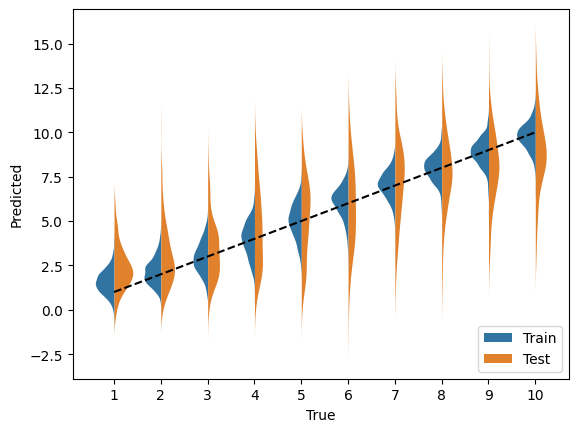

In [176]:
# number of parameter classes
groups = 10

# create figure
fig, ax = plt.subplots()

# make violin plot for test and train
sns.violinplot(data=df,
               x="expect",
               y="predict",
               hue="dataset",
               split=True,
               inner=None,
               linewidth=0)

# add labels
plt.legend(labels=["Train", "Test"], loc="lower right")
plt.plot([0, groups-1], [1, groups], "k--")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()